# filterPairsMetric

A metric to evaluate LSST's ability to discover unknown. It count the number of visits for each filter pairs within time $\Delta t$ and plot the result as a heat map in filter space or skymap for one of the filter pairs. This metric is able to check whether our observation strategy is biased to some filters for a field or the whole sky.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db

In [2]:
# connect to opsim database
opsdb_baseline = db.OpsimDatabase('opsdb/baseline2018a.db')
opsdb_pontus = db.OpsimDatabase('opsdb/pontus_2573.db')

# output directory
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
class filterPairsMetric(metrics.BaseMetric):
    """
    returns skymap or heatmap 
    """
    
    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                 filename='test_pkl.pkl', deltaT=1.5, fltpair=['y','i'], dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.deltaT = deltaT
        self.fltpair = fltpair
        self.dataout = dataout
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
        
    def fmatric(self, dataSlice):
        '''return matric in filter space'''
        timeCol = dataSlice['observationStartMJD']
        
        timeCol = timeCol.reshape((len(timeCol), 1))
        # calculate the difference between each time
        diffmat = np.subtract(timeCol, timeCol.T)
        
        dt_in = self.deltaT / 24
        # get index of items that meet requirements
        idx2, idx1 = np.where((diffmat < dt_in) & (diffmat > 0))
        f1 = dataSlice['filter'][idx1]
        f2 = dataSlice['filter'][idx2]

        flt = ['u', 'g', 'r', 'i', 'z', 'y']
        fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

        fmatric = np.zeros((len(fdict), len(fdict)))
        for i in range(len(f1)):
            fmatric[fdict[f1[i]], fdict[f2[i]]] +=1
            if f1[i] != f2[i]:
                fmatric[fdict[f2[i]], fdict[f1[i]]] +=1 # become symmetry

        return fmatric
    
    def load_from_pkl(self, filename="test_pkl.pkl"):
        '''load dataframe from pickle'''
        if os.path.isfile(filename):
            df = pd.read_pickle(filename)
        else:
            df = pd.DataFrame()
            df.to_pickle(filename)
        return df
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        df = self.load_from_pkl(filename)

        df = df.append(pd.DataFrame(dic), ignore_index=True)

        df.to_pickle(filename)
    
    def run(self, dataSlice, slicePoint=None):
        # sort dataSlice
        flt = ['u', 'g', 'r', 'i', 'z', 'y']
        fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

        dataSlice.sort(order='observationStartMJD')

        fmatric = self.fmatric(dataSlice)
        #print(type(dataSlice['fieldRA']), dataSlice['fieldDec'])
        fmatric_list = []
        for i in range(len(dataSlice['fieldRA'])):
            fmatric_list.append(fmatric)
        
        dic = {'ra':dataSlice['fieldRA'], 'dec':dataSlice['fieldDec'], 'fmatric': fmatric_list}
        # save to file
        self.save_to_file(dic, self.filename)
        
        # return dataSlice directly
        if self.dataout:
            result = fmatric
            return result
        else:
            f0 = self.fltpair[0]
            f1 = self.fltpair[1]
            result = fmatric[fdict[f0],fdict[f1]]
            return float(result)
        

In [4]:
# run the metric, check same filename in folder
metric = filterPairsMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                             filename='fmatric.pkl', deltaT=1.5, fltpair=['r','i'], dataout=False)
slicer = slicers.HealpixSlicer(nside=16)

sqlconstraint = 'night<300 and proposalId=3'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb_pontus, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<300 and proposalId=3 for columns ['fieldRA', 'fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldDec']
Found 161658 visits
Running:  ['metricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "night<300 and proposalId=3" constraint now.
monopole: 16.2377  dipole: lon: -152.901, lat: -20.9504, amp: 6.29482
Plotting complete.


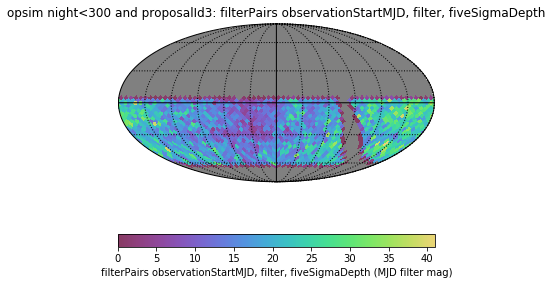

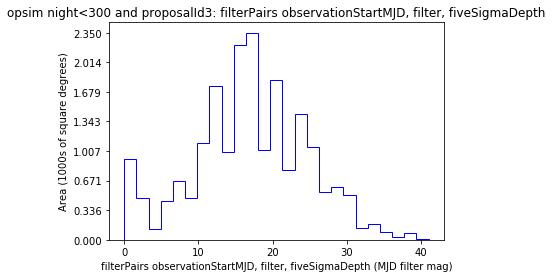

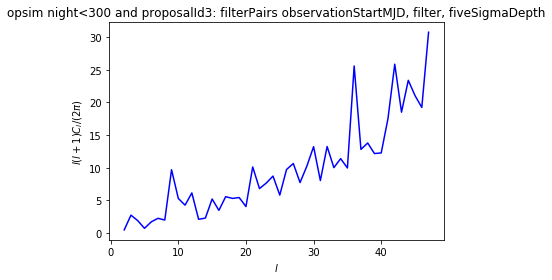

In [5]:
group.plotAll(closefigs=False)

In [6]:
def plot_mwd(RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> plot_mwd(df['ra'], df['dec'], df['metricValues'])
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    #ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='.')  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    plt.colorbar(sc)

In [7]:
def get_element(fmatric, f0='y', f1='y'):
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}

    return fmatric[fdict[f0], fdict[f1]]

def plot_skymap(df, f0='y', f1='z'):
    c = df['fmatric'].apply(get_element, args=(f0, f1))
    plot_mwd(df.ra, df.dec, c, title='filter %s-%s'%(f0, f1))
    
def plot_heatmap(df, idx=0):
    flt = flt = ['u', 'g', 'r', 'i', 'z', 'y']
    sn.heatmap(df['fmatric'][idx], annot=True, xticklabels=flt,yticklabels=flt, 
               cmap='Reds', linewidths=.5)
    plt.title('field %i'%idx)

###### load saved pickle file and plot skymap for any wanted filter pairs 

In [8]:
df = pd.read_pickle('fmatric.pkl')
df.head()

,dec,fmatric,ra
0,3.416542,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....",3.382071
1,3.913711,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....",8.149700
2,3.361560,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....",8.845431
3,3.361560,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....",8.845431
4,3.199113,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....",8.003642


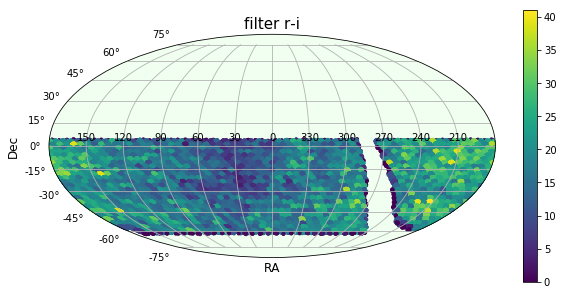

In [9]:
plot_skymap(df, f0='r', f1='i')

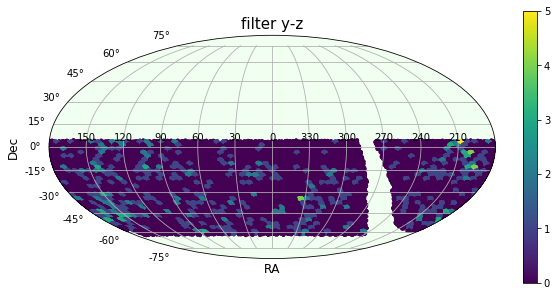

In [10]:
plot_skymap(df, f0='y', f1='z')

In [11]:
df['fmatric'][600]

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  0.],
       [ 0.,  1.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

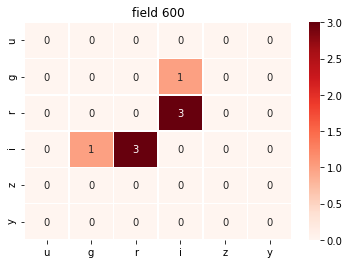

In [12]:
plot_heatmap(df, idx=600)

#### for baseline

In [24]:
# run the metric, check same filename in folder
metric = filterPairsMetric(colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], 
                             filename='fmatric_baseline.pkl',deltaT=1.5, fltpair=['r','i'], dataout=False)
slicer = slicers.HealpixSlicer(nside=16)

sqlconstraint = 'night<300 and proposalId=3'
metricSky = metricBundles.MetricBundle(metric,slicer,sqlconstraint)

group = metricBundles.MetricBundleGroup({'metricSky':metricSky}, opsdb_baseline, outDir=outDir, resultsDb=resultsDb)
group.runAll()

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint night<300 and proposalId=3 for columns ['fiveSigmaDepth', 'filter', 'observationStartMJD', 'fieldDec', 'fieldRA']
Found 170809 visits
Running:  ['metricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [25]:
df = pd.read_pickle('fmatric_baseline.pkl')
df.head()

,dec,fmatric,ra
0,2.635044,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 2.0, 0....",0.0
1,2.635044,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 2.0, 0....",0.0
2,2.635044,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 2.0, 0....",0.0
3,2.635044,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 2.0, 0....",0.0
4,2.635044,"[[0.0, 0.0, 0.0, 1.0, 0.0, 0.0], [0.0, 2.0, 0....",0.0


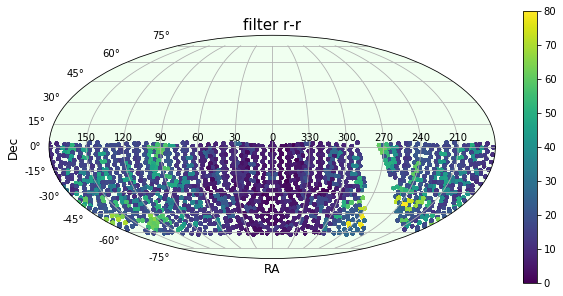

In [29]:
plot_skymap(df, f0='r', f1='r')

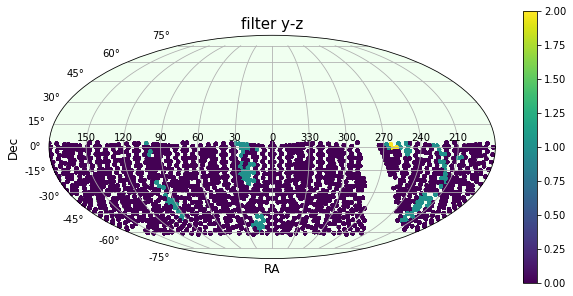

In [26]:
plot_skymap(df, f0='y', f1='z')

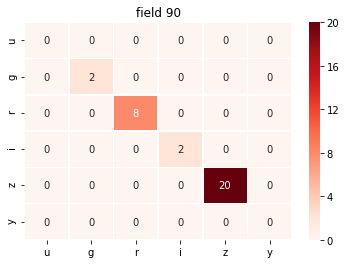

In [27]:
plot_heatmap(df, idx=90)

### Summary

Pontus_2573 has more filters for visits within 1.5 hours.